In [119]:
import os
import csv
import numpy as np
import allan_variance
import matplotlib.pyplot as plt
from tqdm import trange
np.random.seed(0)

In [120]:
def wedge(a):
    Ahat = np.array([[0, -a[2], a[1]],
                    [a[2], 0, -a[0]],
                    [-a[1], a[0], 0]])
    return Ahat

def csv_write(data, filename):
    filepath = os.getcwd()
    with open(os.path.join(filepath, filename), 'w') as f:
        wh = csv.writer(f, delimiter =' ', quoting=csv.QUOTE_NONE)
        for datum in data:
            wh.writerow(['{:.6f}'.format(x) for x in datum])

In [121]:
def measurement(omega, omega_dot, sf, pos_r, Rb_si, num_imus):
    meas = np.zeros(6*num_imus)
    for i in range(num_imus):
        Rb_si_sub = Rb_si[i]
        r_sub = pos_r[i]
        s_i = Rb_si_sub @ (sf + wedge(omega) @ wedge(omega) @ r_sub + wedge(omega_dot) @ r_sub)
        omega_i = Rb_si_sub @ omega
        meas[i*6:6+i*6] = np.concatenate((s_i, omega_i))
    return meas

def sim_QN(meas, gyro_range, accel_range, gyro_bits, accel_bits, num_imus):
    quantized_data = np.zeros(6*num_imus)
    quantization_noise = np.zeros(6*num_imus)
    for i in range(num_imus):
        accel_quantization_step = (2 * accel_range) / (2 ** accel_bits)
        gyro_quantization_step  = (2 * gyro_range) / (2 ** gyro_bits)
        quantized_data[i*6:3+i*6]   = np.round(meas[i*6:3+i*6] / accel_quantization_step) * accel_quantization_step # sf
        quantized_data[i*6+3:6+i*6] = np.round(meas[i*6+3:6+i*6] / gyro_quantization_step) * gyro_quantization_step # omega
        quantization_noise[i*6:6+i*6] = quantized_data[i*6:6+i*6] - meas[i*6:6+i*6]

    return quantized_data, quantization_noise

In [122]:
num_imus = 3

time = np.arange(0, 360, 0.01)
WN_sf = 7.36e-4*np.ones(3)
WN_w =  0.018*np.ones(3)
WN_STD = np.tile(np.concatenate((WN_sf, WN_w)), num_imus)
RW_sf = 6.82e-4*np.ones(3)
RW_w =  3.33e-4*np.ones(3)
RW_STD = np.tile(np.concatenate((RW_sf, RW_w)), num_imus)
B         = 3.3e-3
bias_var  = ((2 * B**2)/np.pi) * np.log(2)
gyro_bits = 16  # 16-bit ADC
accel_bits = 16  # 16-bit ADC
accel_range = 16  # Range of accelerometer in g's
gyro_range = 300  # Range of gyroscope in degrees/sec

WN = np.zeros((len(time), 6*num_imus))
RW = np.zeros((len(time), 6*num_imus))
rw = np.zeros((len(time), 6*num_imus))
w_bias = np.zeros((len(time), 6*num_imus))

for i in range(len(time)):
    WN[i,:] = np.random.normal(loc=0, scale=WN_STD, size=6*num_imus)

for i in range(len(time)):
    rw[i,:] = np.random.normal(loc=0, scale=RW_STD, size=6*num_imus)

for i in range(1, len(time)):
    RW[i,:] = RW[i-1,:] + rw[i-1,:]

for i in range(1, len(time)):
    w_bias[i,:] = np.random.normal(0, np.sqrt(bias_var))

In [123]:
filename = "../data/imu1.txt"

dt = 1e-2
angvel_magnitude = 1
num_steps = int(360/dt)
Rb_si = [np.eye(3), np.eye(3), np.eye(3)] # Rotation matrix
pos_r = np.array([[0.0, 0.0, 0.1],
         [0.0, 0.1, 0.0],
         [0.0, 0.0, 0.0]])

omega = np.array([1, 1, 1])
omega_dot = np.array([0, 0, 0])
sf = np.array([0, 0, 9.81])

time = np.arange(0, 360, 0.01)
state = np.zeros(9 + 6*num_imus)
state[0:3] = omega
state[6:9] = sf
meas_hist = np.zeros((len(time),6*num_imus))
quantized_hist = np.zeros((len(time),6*num_imus))
QN_hist = np.zeros((len(time),6*num_imus))

for i in trange(len(time)):
    meas = measurement(omega, omega_dot, sf, pos_r, Rb_si, num_imus)
    meas_noise = meas + WN[i] + RW[i]
    quantized_data, QN = sim_QN(meas_noise, gyro_range, accel_range, gyro_bits, accel_bits, num_imus)
    meas_hist[i] = meas_noise
    quantized_hist[i] = quantized_data
    # meas_hist[i] = quantized_data
    QN_hist[i] = QN
    
csv_write(quantized_hist, filename)

100%|██████████| 36000/36000 [00:05<00:00, 6624.01it/s]


Text(0.5, 0, 'Time (s)')

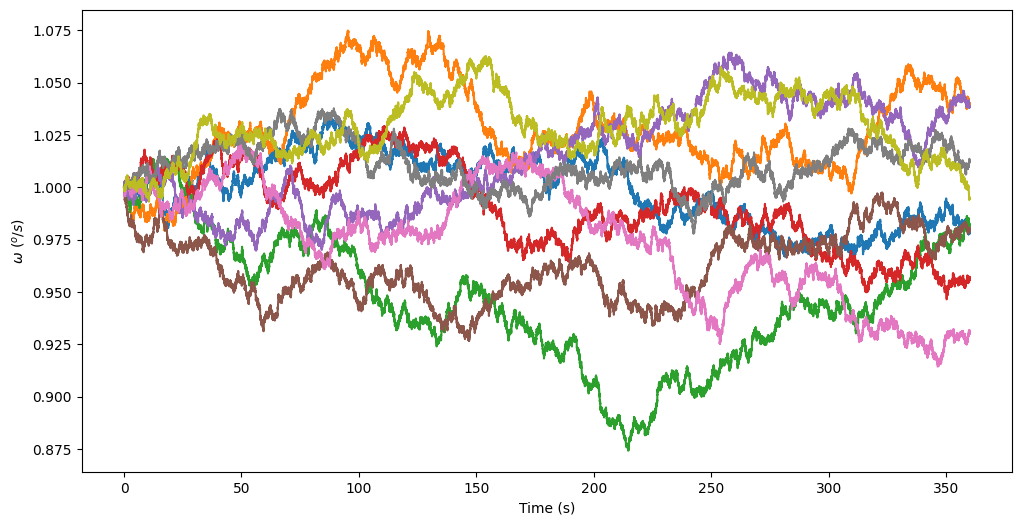

In [124]:
plt.figure(figsize = (12, 6))
for j in range(num_imus):
    plt.plot(time, meas_hist[:,j*6+3])
    plt.plot(time, meas_hist[:,j*6+4])
    plt.plot(time, meas_hist[:,j*6+5])
plt.ylabel("$\omega$ ($^o/s$)")
plt.xlabel("Time (s)")

Text(0.5, 0, 'Time (s)')

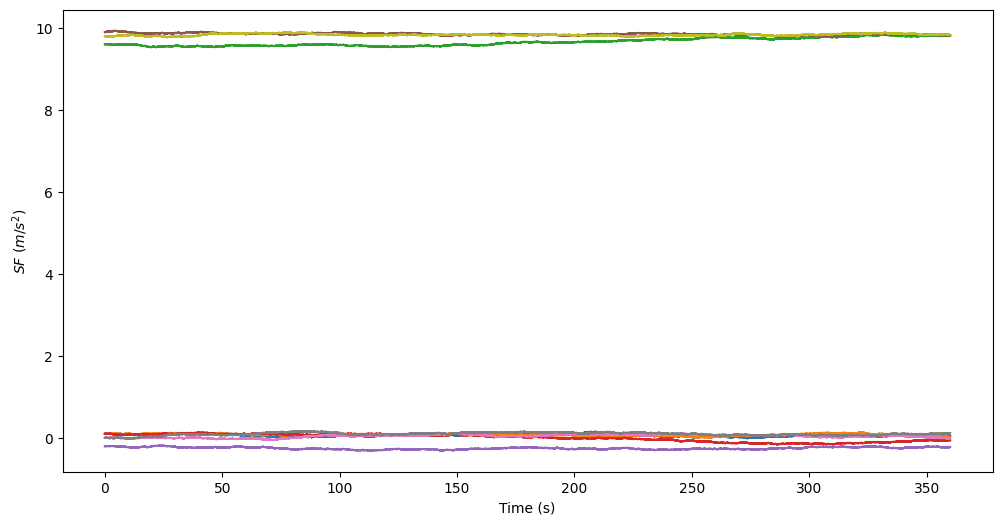

In [125]:
plt.figure(figsize = (12, 6))
for j in range(num_imus):
    plt.plot(time, meas_hist[:,j*6])
    plt.plot(time, meas_hist[:,j*6+1])
    plt.plot(time, meas_hist[:,j*6+2])
plt.ylabel("$SF$ ($m/s^2$)")
plt.xlabel("Time (s)")

IMU 1 SF hat: quantization    0.00000257300028
white           0.00006418049771
flicker         0.00000000000000
walk            0.00704590089797
ramp            0.00050881310916
Name: 0, dtype: float64, quantization    0.00000326635647
white           0.00000000000000
flicker         0.00081269545637
walk            0.00637000862155
ramp            0.00000000000000
Name: 0, dtype: float64, quantization    0.00000309245506
white           0.00005847114800
flicker         0.00000000000000
walk            0.00707608305641
ramp            0.00058842860842
Name: 0, dtype: float64
IMU 2 SF hat: quantization    0.00000287930441
white           0.00000000000000
flicker         0.00091247469330
walk            0.00593922122546
ramp            0.00056898399275
Name: 0, dtype: float64, quantization    0.00000270263711
white           0.00000000000000
flicker         0.00093225243417
walk            0.00593806128235
ramp            0.00000000000000
Name: 0, dtype: float64, quantization    0.00000

Text(0, 0.5, 'Allan Variance ($\\omega$)')

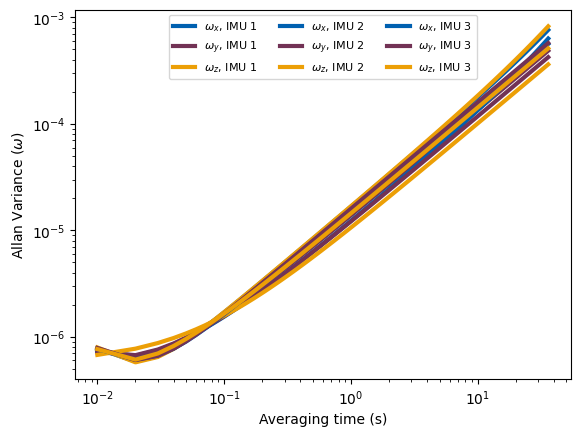

In [126]:
# individual IMUs, omega hat
fig, ax = plt.subplots()
for j in range(num_imus):
    tau_wx, avar_wx = allan_variance.compute_avar(meas_hist[:,j*6], dt)
    tau_wy, avar_wy = allan_variance.compute_avar(meas_hist[:,j*6+1], dt)
    tau_wz, avar_wz = allan_variance.compute_avar(meas_hist[:,j*6+2], dt)
    params_wx, avar_pred_wx = allan_variance.estimate_parameters(tau_wx, avar_wx)
    params_wy, avar_pred_wy = allan_variance.estimate_parameters(tau_wy, avar_wy)
    params_wz, avar_pred_wz = allan_variance.estimate_parameters(tau_wz, avar_wz)
    print(f"IMU {j+1} SF hat: {params_wx}, {params_wy}, {params_wz}")

    # Estimated
    plt.loglog(tau_wx, avar_pred_wx, '-', label="$\omega_x$"+f", IMU {j+1}", linewidth=3, color = "#0060B0")
    plt.loglog(tau_wy, avar_pred_wy, '-', label="$\omega_y$"+f", IMU {j+1}", linewidth=3, color = "#723255")
    plt.loglog(tau_wz, avar_pred_wz, '-', label="$\omega_z$"+f", IMU {j+1}", linewidth=3, color = "#EC9F06")

# ax.set_ylim([0.00000001, 0.01])
plt.legend(ncol=3, fancybox=True, frameon=True, fontsize=8, loc='upper center')
plt.xlabel("Averaging time (s)")
plt.ylabel("Allan Variance ($\omega$)")

IMU 1 SF hat: quantization    0.00000000000000
white           0.00000000000000
flicker         0.00044774114528
walk            0.00259752127289
ramp            0.00000000000000
Name: 0, dtype: float64, quantization    0.00000128273006
white           0.00000000000000
flicker         0.00000000000000
walk            0.00346016809195
ramp            0.00043727591477
Name: 0, dtype: float64, quantization    0.00000127578241
white           0.00000000000000
flicker         0.00000000000000
walk            0.00348923251024
ramp            0.00045906546727
Name: 0, dtype: float64/n
IMU 2 SF hat: quantization    0.00000058348665
white           0.00000000000000
flicker         0.00031214557467
walk            0.00312387655603
ramp            0.00000000000000
Name: 0, dtype: float64, quantization    0.00000061236767
white           0.00000000000000
flicker         0.00030368088679
walk            0.00310823281580
ramp            0.00000000000000
Name: 0, dtype: float64, quantization    0.000

Text(0, 0.5, 'Allan Variance ($s$)')

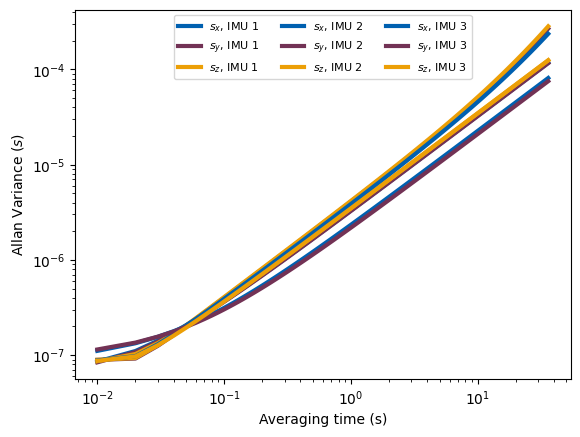

In [127]:
# individual IMUs, SF hat
fig, ax = plt.subplots()
for j in range(num_imus):
    tau_fx, avar_fx = allan_variance.compute_avar(meas_hist[:,j*6+3], dt)
    tau_fy, avar_fy = allan_variance.compute_avar(meas_hist[:,j*6+4], dt)
    tau_fz, avar_fz = allan_variance.compute_avar(meas_hist[:,j*6+5], dt)
    params_fx, avar_pred_fx = allan_variance.estimate_parameters(tau_fx, avar_fx)
    params_fy, avar_pred_fy = allan_variance.estimate_parameters(tau_fy, avar_fy)
    params_fz, avar_pred_fz = allan_variance.estimate_parameters(tau_fz, avar_fz)
    print(f"IMU {j+1} SF hat: {params_fx}, {params_fy}, {params_fz}/n")

    # Estimated
    plt.loglog(tau_fx, avar_pred_fx, '-', label="$s_x$"+f", IMU {j+1}", linewidth=3, color = "#0060B0")
    plt.loglog(tau_fy, avar_pred_fy, '-', label="$s_y$"+f", IMU {j+1}", linewidth=3, color = "#723255")
    plt.loglog(tau_fz, avar_pred_fz, '-', label="$s_z$"+f", IMU {j+1}", linewidth=3, color = "#EC9F06")

# ax.set_ylim([0.00000001, 0.01])
plt.legend(ncol=3, fancybox=True, frameon=True, fontsize=8, loc='upper center')
plt.xlabel("Averaging time (s)")
plt.ylabel("Allan Variance ($s$)")